## Problemstellung

Eine Bank möchte die **Kreditwürdigkeit** ihrer Kunden vorhersagen.  
Auf Basis von Kundendaten (z. B. Kontostatus, Kredithistorie, Einkommen, Beschäftigung, Alter, usw.) soll ein Vorhersagemodell entwickelt werden, das jeden Kunden in eine der beiden Klassen einordnet:

- **kreditwürdig (1)**  
- **nicht kreditwürdig (2)**  

Besonderheit ist das von der Bank vorgegebene **Kostenmodell**:  

- Einen *nicht kreditwürdigen Kunden fälschlich als kreditwürdig* einzustufen, verursacht **fünfmal höhere Kosten** als den umgekehrten Fehler (*kreditwürdigen Kunden fälschlich als nicht kreditwürdig*).  

Daraus ergibt sich ein **überwachtes Klassifikationsproblem mit asymmetrischen Fehlkosten**.  

- **Zielvariable (Label):** `Creditworthy`  
- **Eingabeattribute:** Kundendaten wie  
  - Status of existing checking account  
  - Duration  
  - Credit history  
  - Purpose  
  - Credit amount  
  - Employment  
  - Job  
  - Foreign worker  
  - usw.


## Datenbereinigung, Transformation & Begründungen

# 1) Datenbereinigung
- Fehlende Werte (`?`) → `NaN`  
  **Warum:** Einheitliche Behandlung fehlender Werte; Pandas/Sklearn erwarten `NaN` für Imputation etc.
- Spalte `foreign_worker` entfernt  
  **Warum (ethisch):** Proxy für Nationalität/Migration → Risiko indirekter Diskriminierung; i. d. R. nicht notwendig für Kreditrisikoabschätzung.

# 2) Transformationen
- **Status** (aus `personal_status_sex`) → zwei Klassen  
  - *Single*: A93, A95  
  - *Not Single*: A91, A92, A94  
  - `personal_status_sex` gelöscht  
  **Warum:** Geschlecht explizit entfernen (Fairness); Beziehungsstatus in grober Form behalten (Interpretierbarkeit, geringere Sensitivität).

- **Job** → binär  
  - *Unskilled*: A171, A172  
  - *Qualified*: A173, A174, A175  
  **Warum (ethisch + technisch):** Urspr. Kategorien enthalten „resident vs. non-resident” (heikel); seltene Klassen machen Modelle instabil und fördern Overfitting.

- **Purpose** → 3 Klassen  
  - *Consumption*: A40–A44, A47  
  - *Investment/Human Capital*: A46, A48, A49  
  - *Other/Repairs*: A45, A410  
  **Warum:** Reduktion der Dimensionalität → stabilere Schätzungen, robustere Imputation, bessere Interpretierbarkeit.

# 3) Ordinale Kodierung (Int64)
- `savings` → `savings_ord`: A61=1, A62=2, A63=3, A64=4, A65=0  
- `checking_status` → `checking_status_ord`: A11=1, A12=2, A13=3, A14=0  
- `employment_since` → `employment_since_ord`: A71=0, A72=1, A73=2, A74=3, A75=4  
- `credit_history` → `credit_history_ord` (höher = besser): A30=4, A31=3, A32=2, A33=1, A34=0  
**Warum:** Diese Merkmale besitzen eine natürliche Rangordnung; ordinal codiert vermeidet falsche Annahmen und behält Monotonie bei. `Int64` erlaubt `NaN`.

# 4) One-Hot / Binär
- `debtors` → `debtors_*` (A101=none, A102=co_applicant, A103=guarantor)  
- `property` → `property_*` (A121=Immobilien, A122=Versicherung, A123=Auto, A124=None)  
- `installment_plans` → `instplan_*` (A141=bank, A142=stores, A143=none)  
- `housing` → `housing_*` (A151=rent, A152=own, A153=free)  
- `telephone` → `telephone_bin` (A191=0, A192=1)  
**Warum:** Nominale Variablen haben keine Ordnung → One-Hot verhindert künstliche Rangannahmen; binär bei „Telefon vorhanden: ja/nein“ ist natürlich.

# 5) Originale nach Kodierung entfernt
`savings`, `checking_status`, `employment_since`, `credit_history`,  
`debtors`, `property`, `installment_plans`, `housing`, `telephone`,  
sowie Hilfsspalten (`*_cat`).  
**Warum:** Redundanz und perfekte Multikollinearität vermeiden; nur die modellrelevanten, bereinigten Features behalten. (Für EDA könnten Originale vor dem Drop inspiziert werden.)

# 6) vollständig numerischer Feature-Satz
- `Status` zusätzlich → `Status_bin` (Single=1, Not Single=0)  
- `purpose` zusätzlich → One-Hot (`purpose_*`) und danach `Status`/`purpose` (kategorial) droppen  
**Warum:** Viele ML-Pipelines erwarten rein numerische Eingaben. Bei linearen Modellen ggf. pro One-Hot-Gruppe eine Basisdroppen (`drop_first=True`).

---

# Ergebnis
- Datensatz **bereinigt**, sensible Merkmale **reduziert/entfernt**, Kategorien **verdichtet** und sinnvoll **kodiert**.  
- Effekte: stabileres Training, geringeres Overfitting-Risiko, robustere Imputation und bessere Nachvollziehbarkeit.


In [121]:
import pandas as pd

# === Pfad zur Datendatei anpassen ===
FILE_PATH = "kredit.dat"     # z.B. "/mnt/data/kredit.dat"
SAVE_CSV = True
CSV_PATH = "kredit_clean.csv"

# Spaltennamen gemäß Datensatz
colnames = [
    "checking_status",           # A11-A14
    "duration_months",
    "credit_history",            # A30-A34
    "purpose",                   # A40-A410
    "credit_amount",
    "savings",                   # A61-A65
    "employment_since",          # A71-A75
    "installment_rate_pct",
    "personal_status_sex",       # A91-A95
    "debtors",                   # A101-A103
    "residence_since",
    "property",                  # A121-A124
    "age_years",
    "installment_plans",         # A141-A143
    "housing",                   # A151-A153
    "existing_credits",
    "job",                       # A171-A175 (incomplete)
    "dependents",
    "telephone",                 # A191-A192
    "foreign_worker",            # A201-A202 (incomplete)
    "target"                     # 1 = good, 2 = bad (je nach Quelle)
]

# 1) Einlesen & fehlende Werte als NaN erfassen
df = pd.read_csv(
    FILE_PATH,
    sep=r"\s+",
    header=None,
    names=colnames,
    na_values=["?"]
)

# 2) 'foreign_worker' aus ethischen Gründen löschen
if "foreign_worker" in df.columns:
    df = df.drop(columns=["foreign_worker"])

# 3) personal_status_sex -> Status (Single vs. Not Single)
status_map = {"A93": "Single", "A95": "Single", "A91": "Not Single", "A92": "Not Single", "A94": "Not Single"}
df["Status"] = df["personal_status_sex"].map(status_map).astype("category")
df = df.drop(columns=["personal_status_sex"], errors="ignore")

# 4) Job -> binär (Unskilled vs. Qualified) als Kategorie (NaN bleibt NaN)
unskilled = {"A171", "A172"}
qualified = {"A173", "A174", "A175"}
def job_to_binary(code):
    if pd.isna(code): return pd.NA
    code = str(code)
    if code in unskilled: return "Unskilled"
    if code in qualified: return "Qualified"
    return pd.NA
df["job"] = df["job"].apply(job_to_binary).astype("category")

# 5) Purpose -> 3 Stufen (NaN bleibt NaN)
consumption = {"A40", "A41", "A42", "A43", "A44", "A47"}
investment = {"A46", "A48", "A49"}
other_repairs = {"A45", "A410"}
def purpose_to_coarse(code):
    if pd.isna(code): return pd.NA
    code = str(code)
    if code in consumption: return "Consumption"
    if code in investment: return "Investment/Human Capital"
    if code in other_repairs: return "Other/Repairs"
    return pd.NA
df["purpose"] = df["purpose"].apply(purpose_to_coarse).astype("category")

# 6) Ordinale Kodierung (NaN -> <NA> via Int64)
df["savings_ord"]            = df["savings"].map({"A61":1,"A62":2,"A63":3,"A64":4,"A65":0}).astype("Int64")
df["checking_status_ord"]    = df["checking_status"].map({"A11":1,"A12":2,"A13":3,"A14":0}).astype("Int64")
df["employment_since_ord"]   = df["employment_since"].map({"A71":0,"A72":1,"A73":2,"A74":3,"A75":4}).astype("Int64")
df["credit_history_ord"]     = df["credit_history"].map({"A30":4,"A31":3,"A32":2,"A33":1,"A34":0}).astype("Int64")

# 7) One-Hot / binär mit NaN-Durchreichung
def one_hot_with_nan(source_series: pd.Series, prefix: str) -> pd.DataFrame:
    """Erzeugt One-Hot-Dummies in Int64 und setzt bei NaN in der Quelle
    die gesamte Dummy-Zeile auf <NA>, statt auf 0."""
    dums = pd.get_dummies(source_series, prefix=prefix, dtype="Int64")
    mask = source_series.isna()
    if mask.any():
        dums.loc[mask, :] = pd.NA
        # Sicherheits-Recast (stellt sicher, dass Int64 erhalten bleibt):
        dums = dums.astype("Int64")
    return dums

# debtors
df["debtors_cat"] = df["debtors"].map({"A101":"none","A102":"co_applicant","A103":"guarantor"})
df = pd.concat([df, one_hot_with_nan(df["debtors_cat"], "debtors")], axis=1)

# property
df["property_cat"] = df["property"].map({"A121":"Immobilien","A122":"Versicherung","A123":"Auto","A124":"None"})
df = pd.concat([df, one_hot_with_nan(df["property_cat"], "property")], axis=1)

# installment plans
df["installment_plans_cat"] = df["installment_plans"].map({"A141":"bank","A142":"stores","A143":"none"})
df = pd.concat([df, one_hot_with_nan(df["installment_plans_cat"], "instplan")], axis=1)

# housing
df["housing_cat"] = df["housing"].map({"A151":"rent","A152":"own","A153":"free"})
df = pd.concat([df, one_hot_with_nan(df["housing_cat"], "housing")], axis=1)

# telephone (NaN bleibt NaN)
df["telephone_bin"] = df["telephone"].map({"A191":0,"A192":1}).astype("Int64")

# 8) Verbindlich: numerischer Satz für Status & Purpose (mit NaN-Durchreichung)
# Status -> binär (NaN bleibt NaN)
df["Status_bin"] = df["Status"].map({"Single":1, "Not Single":0}).astype("Int64")

# purpose -> One-Hot (NaN bleibt NaN in allen purpose_* Spalten)
purpose_dummies = one_hot_with_nan(df["purpose"], "purpose")
df = pd.concat([df, purpose_dummies], axis=1)

# Optional: job zusätzlich numerisch (NaN bleibt NaN)
df["job_bin"] = df["job"].map({"Unskilled":0, "Qualified":1}).astype("Int64")

# 9) Jetzt ALLE Original-Kategorien in EINEM Schritt droppen
drop_cols = [
    "savings","checking_status","employment_since","credit_history",
    "debtors","property","installment_plans","housing","telephone",
    "debtors_cat","property_cat","installment_plans_cat","housing_cat",
    "Status","purpose","job"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 10) Ausgabe & Speichern
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)
print(df.head(10).to_string(index=False))


 duration_months  credit_amount  installment_rate_pct  residence_since  age_years  existing_credits  dependents  target  savings_ord  checking_status_ord  employment_since_ord  credit_history_ord  debtors_co_applicant  debtors_guarantor  debtors_none  property_Auto  property_Immobilien  property_None  property_Versicherung  instplan_bank  instplan_none  instplan_stores  housing_free  housing_own  housing_rent  telephone_bin  Status_bin  purpose_Consumption  purpose_Investment/Human Capital  purpose_Other/Repairs  job_bin
              36           2299                     4                4         39                 1           1       1            3                    0                  <NA>                   2                     0                  0             1              1                    0              0                      0              0              1                0             0            1             0              0           1                 <NA>             

jetzt gucken wir wie Daten verteilt sind

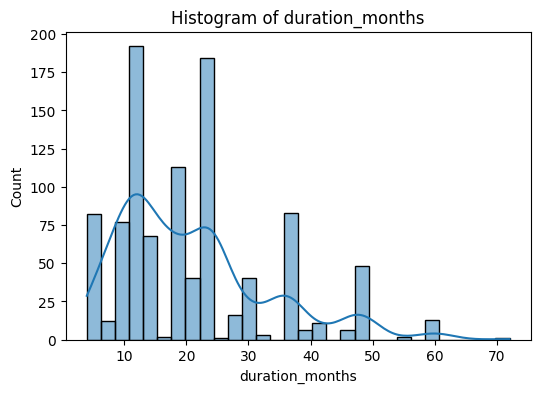

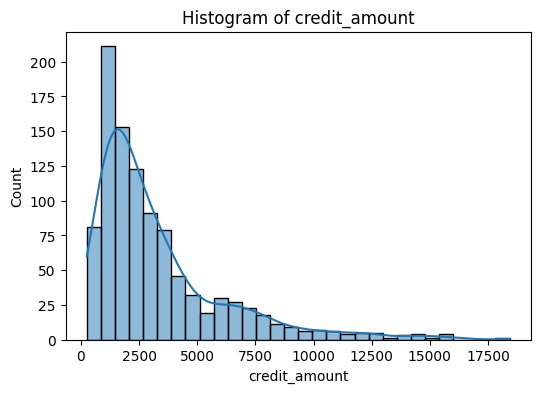

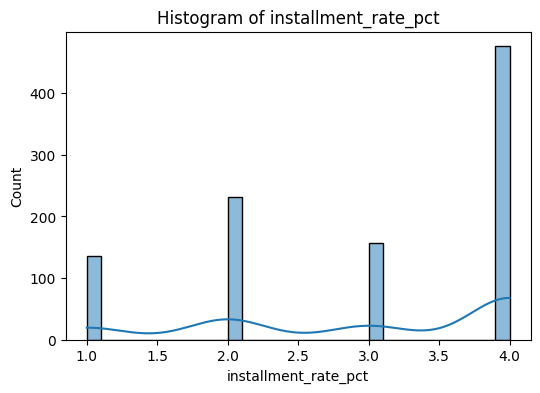

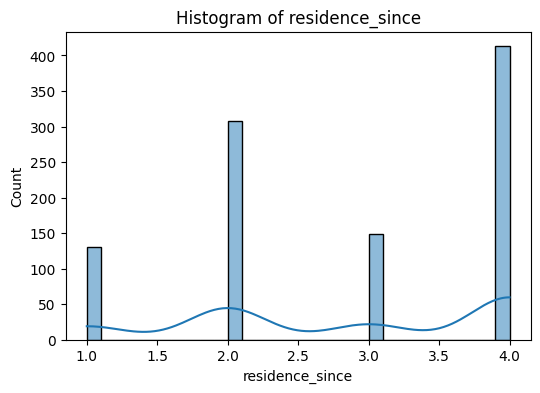

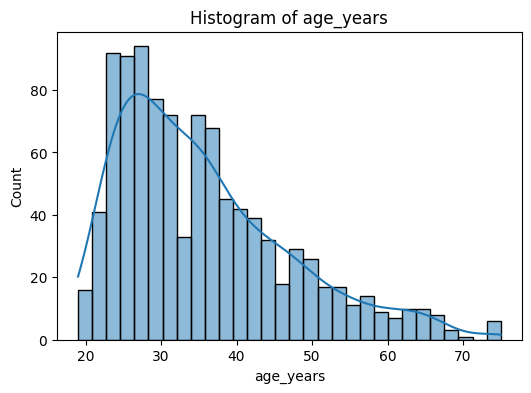

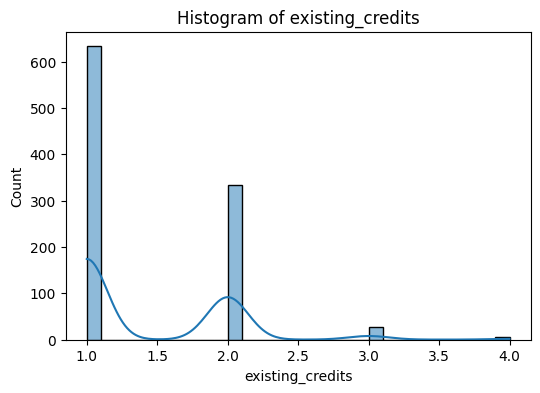

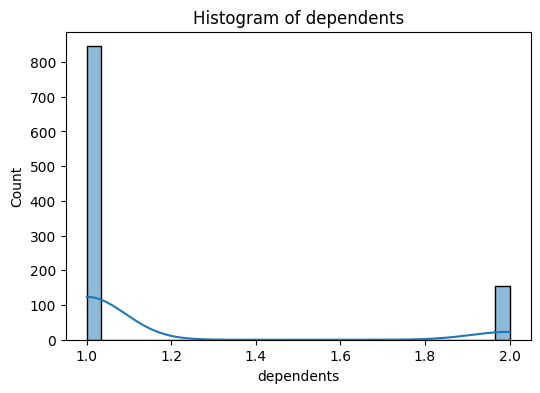

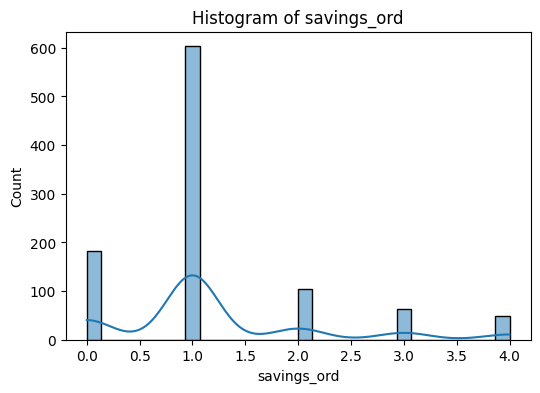

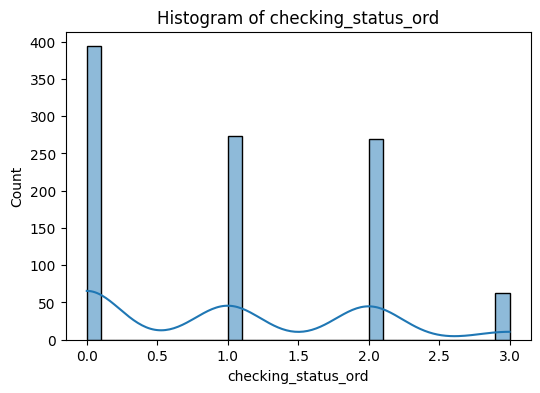

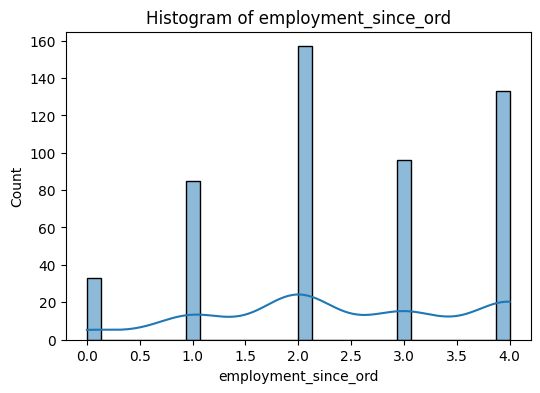

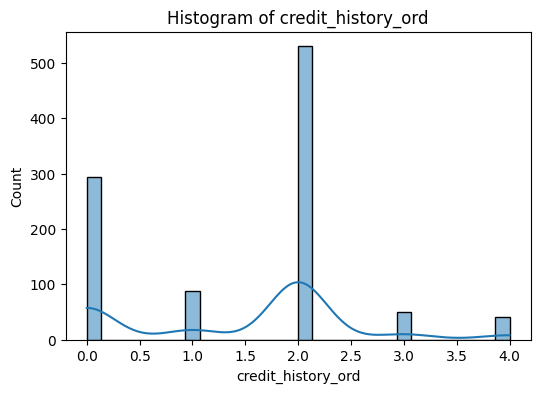

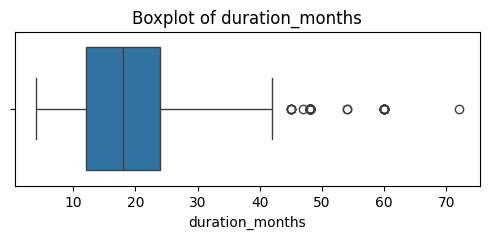

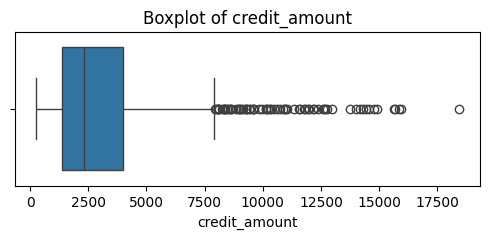

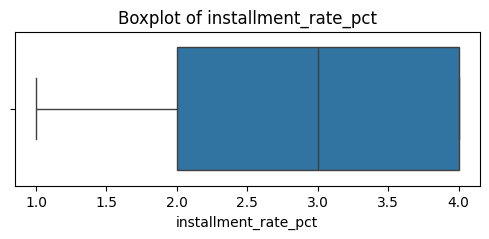

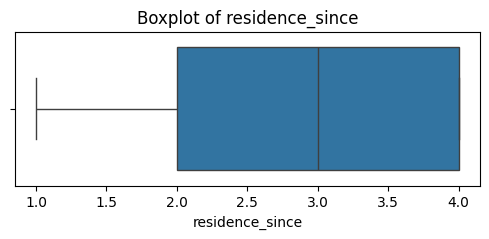

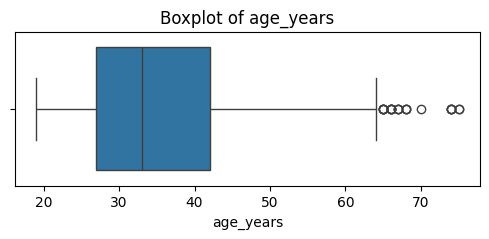

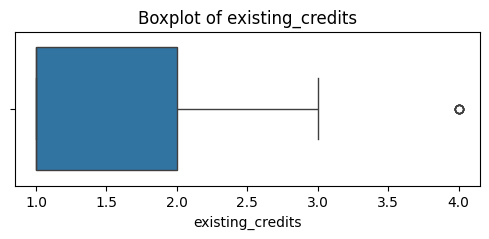

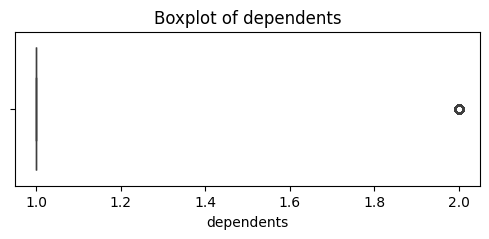

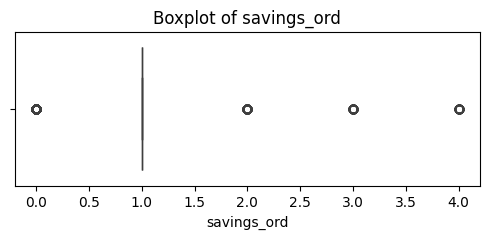

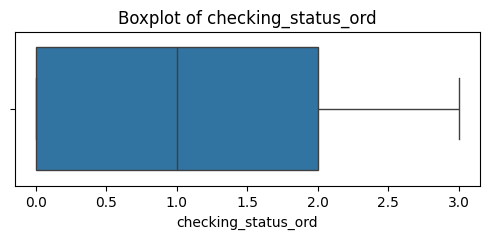

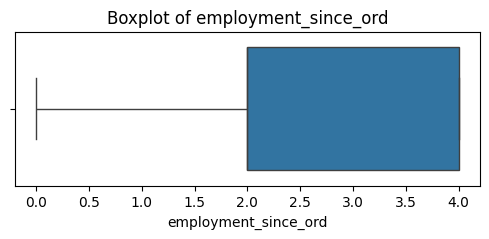

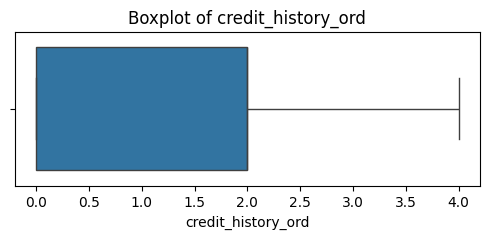

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste der Spalten, die normalisiert werden könnten
numeric_cols = [
    "duration_months",
    "credit_amount",
    "installment_rate_pct",
    "residence_since",
    "age_years",
    "existing_credits",
    "dependents",
    "savings_ord",
    "checking_status_ord",
    "employment_since_ord",
    "credit_history_ord"
]

# Histogramme für jede Variable
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f"Histogram of {col}")
    plt.show()

# Boxplots um Ausreißer zu erkennen
for col in numeric_cols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.show()

und jetzt normalisiere ich alles mit StandardScaler außer binäre Werte und Credit amount. Bei dem letzten verwende ich ein Robuster Scaler

In [123]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

# CSV laden
df = pd.read_csv("kredit_clean.csv")

# Spalten definieren
robust_cols = ["credit_amount"]

standard_cont_cols = [
    "duration_months",
    "age_years",
    "installment_rate_pct",
    "residence_since",
    "existing_credits",
    "dependents",
]

standard_ordinal_cols = [
    "savings_ord",
    "checking_status_ord",
    "employment_since_ord",
    "credit_history_ord",
]

binary_cols = [
    "debtors_co_applicant", "debtors_guarantor", "debtors_none",
    "property_Auto", "property_Immobilien", "property_None", "property_Versicherung",
    "instplan_bank", "instplan_none", "instplan_stores",
    "housing_free", "housing_own", "housing_rent",
    "telephone_bin", "Status_bin",
    "purpose_Consumption", "purpose_Investment/Human Capital", "purpose_Other/Repairs",
    "job_bin",
]

used_cols = robust_cols + standard_cont_cols + standard_ordinal_cols + binary_cols
X = df[used_cols].copy()

# Pipelines ohne Imputer -> NaN bleibt erhalten
robust_num = Pipeline(steps=[
    ("scale", RobustScaler())
])

standard_cont = Pipeline(steps=[
    ("scale", StandardScaler())
])

standard_ordinal = Pipeline(steps=[
    ("scale", StandardScaler())
])

passthrough_bin = "passthrough"

# ColumnTransformer
preprocess = ColumnTransformer(transformers=[
    ("robust_num", robust_num, robust_cols),
    ("standard_cont", standard_cont, standard_cont_cols),
    ("standard_ordinal", standard_ordinal, standard_ordinal_cols),
    ("bin", passthrough_bin, binary_cols),
], remainder="drop")

# Fit & Transform
X_scaled = preprocess.fit_transform(X)

# DataFrame mit Spaltennamen
scaled_cols = robust_cols + standard_cont_cols + standard_ordinal_cols + binary_cols
X_scaled_df = pd.DataFrame(X_scaled, columns=scaled_cols, index=df.index)

# Wieder ins Original einbauen (target bleibt unberührt)
df = pd.concat([df.drop(columns=scaled_cols), X_scaled_df], axis=1)

print(df.head(10).to_string(index=False))


 target  credit_amount  duration_months  age_years  installment_rate_pct  residence_since  existing_credits  dependents  savings_ord  checking_status_ord  employment_since_ord  credit_history_ord  debtors_co_applicant  debtors_guarantor  debtors_none  property_Auto  property_Immobilien  property_None  property_Versicherung  instplan_bank  instplan_none  instplan_stores  housing_free  housing_own  housing_rent  telephone_bin  Status_bin  purpose_Consumption  purpose_Investment/Human Capital  purpose_Other/Repairs  job_bin
      1      -0.007864         1.252574   0.303788              0.918477         1.046987         -0.704926   -0.428290     1.872960            -1.046463                   NaN            0.503428                   0.0                0.0           1.0            1.0                  0.0            0.0                    0.0            0.0            1.0              0.0           0.0          1.0           0.0            0.0         1.0                  NaN             

In [124]:
# Anzahl fehlender Werte je Spalte
missing_counts = df.isna().sum()

# Anteil in Prozent
missing_percent = (df.isna().mean() * 100).round(2)

# Zusammenführen in ein DataFrame
missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
})

print(missing_summary.to_string())

                                  missing_count  missing_percent
target                                        0              0.0
credit_amount                                 0              0.0
duration_months                               0              0.0
age_years                                     0              0.0
installment_rate_pct                          0              0.0
residence_since                               0              0.0
existing_credits                              0              0.0
dependents                                    0              0.0
savings_ord                                   0              0.0
checking_status_ord                           0              0.0
employment_since_ord                        496             49.6
credit_history_ord                            0              0.0
debtors_co_applicant                          0              0.0
debtors_guarantor                             0              0.0
debtors_none             

# Imputation Pipeline (Purpose, Job, Employment)

Dieses Skript behandelt fehlende Werte (`NaN`) in den Spalten **Purpose**, **Job** und **Employment** mithilfe von linearen / logistischen Modellen.

## Schritte

1. **Purpose**
   - Multinomiale logistische Regression (`LogisticRegression`, `solver="saga"`)
   - Class balancing (`class_weight="balanced"`)
   - Scoring: `precision_weighted` + Accuracy
   - Rückschreiben in die ursprünglichen Dummy-Spalten (`purpose_Consumption`, `purpose_Investment/Human Capital`, `purpose_Other/Repairs`).

2. **Job**
   - Binäre logistische Regression (`LogisticRegression`, `solver="liblinear"`)
   - Class balancing (`class_weight="balanced"`)
   - Scoring: `precision_weighted` + Accuracy
   - Fehlende Werte in `job_bin` werden ersetzt.

3. **Employment**
   - Lineare Regression (hier Ridge/Lasso möglich, aktuell Ridge mit Best-Alpha via CV)
   - Scoring: MAE (Mean Absolute Error) + Ordinal Accuracy
   - Rundung + Clipping auf 0–4 (Kategorien).

## Evaluation

- Nested Cross-Validation (10-fold outer, 5-fold inner)
- Reportete Metriken:
  - **Purpose**: Precision (weighted) & Accuracy
  - **Job**: Precision (weighted) & Accuracy
  - **Employment**: MAE & Ordinal Accuracy

## Ergebnisse (aktuell)

- **Purpose**: Precision ≈ 0.75 ± 0.06 | Accuracy ≈ 0.84  
- **Job**: Precision ≈ 0.80 ± 0.02 | Accuracy ≈ 0.70  
- **Employment**: MAE ≈ 0.57 ± 0.05 | Ordinal Accuracy ≈ 0.64  

→ Ergebnisse sind für den Imputationszweck stabil und gut nutzbar.


In [125]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from sklearn.metrics import mean_absolute_error

# ======================================================================
# Konfiguration
# ======================================================================
RANDOM_STATE = 42
OUTER_FOLDS = 10
BIG_C = 1e10                      # ~keine Regularisierung für LogReg (L2)
C_GRID_EMP = [0.1, 1.0, 10.0]     # für Employment -> alpha_grid = 1/C
ALPHA_GRID_EMP = [1.0 / c for c in C_GRID_EMP]

# ======================================================================
# Hilfsfunktionen
# ======================================================================
def clip_round(arr, low=0, high=4):
    arr = np.rint(arr)
    return np.clip(arr, low, high).astype(int)

def ordinal_acc(y_true, y_pred_cont, low=0, high=4):
    yp = clip_round(y_pred_cont, low, high)
    return (yp == y_true.astype(int)).mean()

def assert_no_nan(df_like, name="X"):
    bad = df_like.isna().sum()
    if hasattr(bad, "sum"):
        tot = int(bad.sum())
        assert tot == 0, f"{name} enthält {tot} NaNs:\n{bad[bad>0].sort_values(ascending=False).head(15)}"
    else:
        assert not np.isnan(df_like).any(), f"{name} enthält NaNs."

# ======================================================================
# 0) Datensatz: Annahme df existiert bereits
# ======================================================================
TARGET_COL = "target" if "target" in df.columns else None

purpose_cols = [
    "purpose_Consumption",
    "purpose_Investment/Human Capital",
    "purpose_Other/Repairs",
]

# ======================================================================
# 1) PURPOSE imputieren (multinomiale LogReg ~ohne Regularisierung), zurück in Original-Dummies
# ======================================================================

# Robuste Ableitung von 'purpose_cat'
P = df[purpose_cols].astype(float)
row_sum = P.fillna(0).sum(axis=1)
valid = (row_sum == 1)
print(f"[PURPOSE] Zeilen ohne Label (alles 0/NaN): {int((row_sum == 0).sum())}")
print(f"[PURPOSE] Zeilen mit mehr als einer aktiven Klasse: {int((row_sum > 1).sum())}")

df["purpose_cat"] = pd.Series(pd.NA, index=df.index, dtype="object")
df.loc[valid, "purpose_cat"] = P.loc[valid].idxmax(axis=1)
mask_purpose = df["purpose_cat"].notna()

# Features/Labels (nur bekannte purpose_cat)
exclude_for_purpose = purpose_cols + ["purpose_cat", "employment_since_ord", "job_bin"]
if TARGET_COL:
    exclude_for_purpose.append(TARGET_COL)
X_purpose = df.loc[mask_purpose, [c for c in df.columns if c not in exclude_for_purpose]]
y_purpose = df.loc[mask_purpose, "purpose_cat"]

assert_no_nan(X_purpose, "X_purpose")
assert_no_nan(y_purpose.to_frame(), "y_purpose")

# Multinomiale LogReg mit lbfgs, l2, riesiges C -> praktisch unregularisiert
logreg_multi = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    penalty="l2",
    C=BIG_C,
    max_iter=2000,
    class_weight=None,           # Fokus auf Precision
    random_state=RANDOM_STATE
)

outer_cv_p = StratifiedKFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Reporting: Precision (weighted) + Accuracy
scoring_purpose = {"precision_weighted": "precision_weighted", "accuracy": "accuracy"}
cvres_p = cross_validate(logreg_multi, X_purpose, y_purpose, cv=outer_cv_p,
                         scoring=scoring_purpose, n_jobs=-1)
print(
    "[PURPOSE] 10-fold CV  precision_weighted: "
    f"{cvres_p['test_precision_weighted'].mean():.3f} ± {cvres_p['test_precision_weighted'].std():.3f} | "
    f"acc: {cvres_p['test_accuracy'].mean():.3f} ± {cvres_p['test_accuracy'].std():.3f}"
)

# Finale Purpose-Imputation
logreg_multi.fit(X_purpose, y_purpose)
if df["purpose_cat"].isna().any():
    X_purpose_missing = df.loc[~mask_purpose, X_purpose.columns]
    assert_no_nan(X_purpose_missing, "X_purpose_missing")
    df.loc[~mask_purpose, "purpose_cat"] = logreg_multi.predict(X_purpose_missing)

# Zurück in die ursprünglichen Dummy-Spalten
df.loc[:, purpose_cols] = 0
for cat in df["purpose_cat"].dropna().unique():
    df.loc[df["purpose_cat"] == cat, cat] = 1
df.drop(columns=["purpose_cat"], inplace=True)
assert_no_nan(df[purpose_cols], "purpose dummy cols")

# ======================================================================
# 2) JOB imputieren (binäre LogReg ~ohne Regularisierung, aber class_weight='balanced')
# ======================================================================
mask_job = df["job_bin"].notna().astype(bool)
exclude_for_job = ["job_bin", "employment_since_ord"]
if TARGET_COL:
    exclude_for_job.append(TARGET_COL)
X_job_cols = [c for c in df.columns if c not in exclude_for_job]
X_job = df.loc[mask_job, X_job_cols]
y_job = df.loc[mask_job, "job_bin"].astype(int)

assert_no_nan(X_job, "X_job")
assert_no_nan(y_job.to_frame(), "y_job")

outer_cv_j = StratifiedKFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

logreg_bin = LogisticRegression(
    solver="lbfgs",
    penalty="l2",
    C=BIG_C,                      # praktisch keine Regularisierung
    max_iter=2000,
    class_weight="balanced",      # hilft bei Imbalance (ohne Laufzeitkosten)
    random_state=RANDOM_STATE
)

scoring_job = {
    "precision_weighted": "precision_weighted",
    "accuracy": "accuracy",
}
cvres_j = cross_validate(logreg_bin, X_job, y_job, cv=outer_cv_j,
                         scoring=scoring_job, n_jobs=-1)
print(
    "[JOB] 10-fold CV  precision_weighted: "
    f"{cvres_j['test_precision_weighted'].mean():.3f} ± {cvres_j['test_precision_weighted'].std():.3f} | "
    f"acc: {cvres_j['test_accuracy'].mean():.3f} ± {cvres_j['test_accuracy'].std():.3f}"
)

# Finale Job-Imputation
logreg_bin.fit(X_job, y_job)
if df["job_bin"].isna().any():
    X_job_missing = df.loc[~mask_job, X_job_cols]
    assert_no_nan(X_job_missing, "X_job_missing")
    df.loc[~mask_job, "job_bin"] = logreg_bin.predict(X_job_missing)

assert df["job_bin"].isna().sum() == 0, "job_bin hat noch Missing-Werte."

# ======================================================================
# 3) EMPLOYMENT imputieren (RidgeCV mit kleinem Alpha-Grid), Reporting MAE & OrdAcc
# ======================================================================
mask_emp = df["employment_since_ord"].notna().astype(bool)
exclude_for_emp = ["employment_since_ord"]
if TARGET_COL:
    exclude_for_emp.append(TARGET_COL)
X_emp_cols = [c for c in df.columns if c not in exclude_for_emp]
X_emp = df.loc[mask_emp, X_emp_cols]
y_emp = df.loc[mask_emp, "employment_since_ord"]

assert_no_nan(X_emp, "X_emp")
assert_no_nan(y_emp.to_frame(), "y_emp")

outer_cv_e = KFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)
mae_list, ordacc_list = [], []
for tr_idx, te_idx in outer_cv_e.split(X_emp):
    Xtr, Xte = X_emp.iloc[tr_idx], X_emp.iloc[te_idx]
    ytr, yte = y_emp.iloc[tr_idx], y_emp.iloc[te_idx]

    ridge_cv = RidgeCV(alphas=ALPHA_GRID_EMP, scoring="neg_mean_absolute_error", cv=5)
    ridge_cv.fit(Xtr, ytr)
    ypred = ridge_cv.predict(Xte)

    mae_list.append(mean_absolute_error(yte, ypred))
    ordacc_list.append(ordinal_acc(yte.values, ypred, low=0, high=4))

print(f"[EMPLOYMENT] {OUTER_FOLDS}-fold CV MAE: mean={np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"[EMPLOYMENT] {OUTER_FOLDS}-fold CV Ordinal-Accuracy: mean={np.mean(ordacc_list):.3f} ± {np.std(ordacc_list):.3f}")

# Finale Imputation mit bestem alpha auf allen bekannten Daten
ridge_cv_full = RidgeCV(alphas=ALPHA_GRID_EMP, scoring="neg_mean_absolute_error", cv=5)
ridge_cv_full.fit(X_emp, y_emp)
best_alpha = ridge_cv_full.alpha_
best_C_emp = 1.0 / best_alpha
print(f"[EMPLOYMENT] Best alpha={best_alpha:.6g} -> Best C≈{best_C_emp:.6g}")

if df["employment_since_ord"].isna().any():
    X_emp_missing = df.loc[~mask_emp, X_emp_cols]
    assert_no_nan(X_emp_missing, "X_emp_missing")
    emp_pred = ridge_cv_full.predict(X_emp_missing)
    df.loc[~mask_emp, "employment_since_ord"] = clip_round(emp_pred, low=0, high=4)

# Final sanity checks
assert df[purpose_cols].isna().sum().sum() == 0, "Purpose-Dummies haben NaNs."
assert df["job_bin"].isna().sum() == 0, "job_bin hat NaNs."
assert df["employment_since_ord"].isna().sum() == 0, "employment_since_ord hat NaNs."

print("✓ Imputation abgeschlossen.")


[PURPOSE] Zeilen ohne Label (alles 0/NaN): 173
[PURPOSE] Zeilen mit mehr als einer aktiven Klasse: 0
[PURPOSE] 10-fold CV  precision_weighted: 0.679 ± 0.028 | acc: 0.810 ± 0.012
[JOB] 10-fold CV  precision_weighted: 0.765 ± 0.054 | acc: 0.663 ± 0.055
[EMPLOYMENT] 10-fold CV MAE: mean=0.748 ± 0.074
[EMPLOYMENT] 10-fold CV Ordinal-Accuracy: mean=0.574 ± 0.053
[EMPLOYMENT] Best alpha=10 -> Best C≈0.1
✓ Imputation abgeschlossen.


In [126]:
print(df.head(10).to_string(index=False))

 target  credit_amount  duration_months  age_years  installment_rate_pct  residence_since  existing_credits  dependents  savings_ord  checking_status_ord  employment_since_ord  credit_history_ord  debtors_co_applicant  debtors_guarantor  debtors_none  property_Auto  property_Immobilien  property_None  property_Versicherung  instplan_bank  instplan_none  instplan_stores  housing_free  housing_own  housing_rent  telephone_bin  Status_bin  purpose_Consumption  purpose_Investment/Human Capital  purpose_Other/Repairs  job_bin
      1      -0.007864         1.252574   0.303788              0.918477         1.046987         -0.704926   -0.428290     1.872960            -1.046463              1.000000            0.503428                   0.0                0.0           1.0            1.0                  0.0            0.0                    0.0            0.0            1.0              0.0           0.0          1.0           0.0            0.0         1.0                  1.0             